In [ ]:
# default_exp gfs

# GFS

> Functions to download GFS data

In [ ]:
# hide
from nbdev.showdoc import *
from nbdev.export import notebook2script
from IPython.core.debugger import set_trace

In [ ]:
# export
import os
import re
import requests
from pathlib import Path
import pandas as pd
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# export
class GFS():
    def __init__(self, path:Path, bbox:list=None, bands_sf:list=None, bands_pl:list=None,
                 last_forecast='f120', **kwargs):
        """
        path - path to save the data; 
        bbox - region bounds in format [left, bottom, right top];
        bands_sf - variables for surface/mean sea level/2m/10m
        bands_pl - variables for pressure levels 1000mb up to 1mb
        last_forecast - download hourly data up to last_forecast step defined
        find_last
        """
        self.path = path
        if isinstance(self.path, str): self.path = Path(self.path)
        self.path.mkdir(exist_ok=True)
        if bbox is None: bbox = [-180, -90, 180, 90]
        self.bbox = bbox # left, bottom, right, top
        self.bands_sf = bands_sf
        self.bands_pl = bands_pl
        self.last_forecast = last_forecast
        self.find_last = True
    
    def search_times(self):
        if self.find_last:
            url = f"https://nomads.ncep.noaa.gov/cgi-bin/filter_gfs_0p25_1hr.pl"
            dates_available = sorted(re.findall('dir=%2Fgfs.(.*?)">', requests.get(url).text))
            url += '?dir=%2Fgfs.' + dates_available[-1]
            runs_available = sorted(re.findall('">(.*?)</a>', requests.get(url).text))
            url += f'%2F{runs_available[-1]}'
            forecast_times = re.findall('pgrb2.0p25.(.*?)">', requests.get(url).text)
            if self.last_forecast in forecast_times:
                return dates_available[-1], runs_available[-1]
            elif len(runs_available)>1:
                return dates_available[-1], runs_available[-2]
            else:
                return dates_available[-2], '18'
        else: return dates_available, runs_available, forecast_times

    def search_files(self, tstr, run_time, forecast_hour):
        path = self.path
        left, bottom, right, top = self.bbox
        file_sf, file_pl = None, None
        if self.bands_sf is not None:
            bands_sf = ''.join([f'&var_{v}=on' for v in self.bands_sf])
            file_sf = f'https://nomads.ncep.noaa.gov/cgi-bin/' \
                   f'filter_gfs_0p25_1hr.pl?file=gfs.t{run_time}z.pgrb2.0p25.{forecast_hour}' \
                   f'&lev_10_m_above_ground=on&lev_2_m_above_ground=on&lev_mean_sea_level=on&lev_surface=on' \
                   f'{bands_sf}' \
                   f'&subregion=&leftlon={left}&rightlon={right}&toplat={top}&bottomlat={bottom}&' \
                   f'dir=%2Fgfs.{tstr}%2F{run_time}'
        if self.bands_pl is not None:
            bands_pl = ''.join([f'&var_{v}=on' for v in self.bands_pl])
            file_pl = f'https://nomads.ncep.noaa.gov/cgi-bin/' \
                   f'filter_gfs_0p25_1hr.pl?file=gfs.t{run_time}z.pgrb2.0p25.{forecast_hour}' \
                   f'&lev_1000_mb=on&lev_100_mb=on&lev_10_mb=on&lev_150_mb=on&lev_15_mb=on&lev_1_mb=on&lev_200_mb=on&lev_20_mb=on&lev_250_mb=on&lev_2_mb=on&lev_300_mb=on&lev_30_mb=on&lev_350_mb=on&lev_3_mb=on&lev_400_mb=on&lev_40_mb=on&lev_450_mb=on&lev_500_mb=on&lev_50_mb=on&lev_550_mb=on&lev_5_mb=on&lev_600_mb=on&lev_650_mb=on&lev_700_mb=on&lev_70_mb=on&lev_750_mb=on&lev_7_mb=on&lev_800_mb=on&lev_850_mb=on&lev_900_mb=on&lev_925_mb=on&lev_950_mb=on&lev_975_mb=on' \
                   f'&var_DPT=on&var_TMP=on&var_UGRD=on&var_VGRD=on' \
                   f'&subregion=&leftlon={left}&rightlon={right}&toplat={top}&bottomlat={bottom}&' \
                   f'dir=%2Fgfs.{tstr}%2F{run_time}'
        return file_sf, file_pl

    def run(self, to_netcdf=True, delete_old=False):
        path = str(self.path)
        tstr, run_time = self.search_times()
        end_forecast = int(self.last_forecast[1:])+1
        forecast_hours = [f'f{i:03d}' for i in range(1,end_forecast)]
        if delete_old: os.system(f'cd {path}; rm *.nc')
        for f in forecast_hours:
            print(f'Downloading data for {tstr} {run_time}z {f}.')
            files = self.search_files(tstr, run_time, f)
            files = [f for f in files if f is not None]
            if len(files)>0:
                for i, file in enumerate(files):
                    if len(files)>1:
                        assert os.system(f'wget "{file}" -O {path}/GFS_{i}_{f}') == 0
                    else:
                        assert os.system(f'wget "{file}" -O {path}/GFS_{f}') == 0
                    if to_netcdf:
                        if len(files)>1:
                            assert os.system(f'cd {path}; cdo -f nc copy GFS_{i}_{f} GFS_{i}_{f}.nc') == 0
                        else:
                            assert os.system(f'cd {path}; cdo -f nc copy GFS_{f} GFS_{f}.nc') == 0
                if to_netcdf:
                    if len(files)>1:
                        os.system(f'cd {path}; cdo -O merge GFS_0_{f}.nc GFS_1_{f}.nc GFS_{f}.nc')
                        os.system(f'cd {path}; rm GFS_0_{f} GFS_1_{f} GFS_0_{f}.nc GFS_1_{f}.nc')
                    else:
                        os.system(f'cd {path}; rm GFS_{f}')

    def __repr__(self):
        s = ''
        for k in self.__dict__:
            s += f'{k}: {self.__dict__[k]}, '
        return s + '\n'

To convert the grib files to netCDF you need to install CDO:
```bash
sudo apt-get install cdo
```

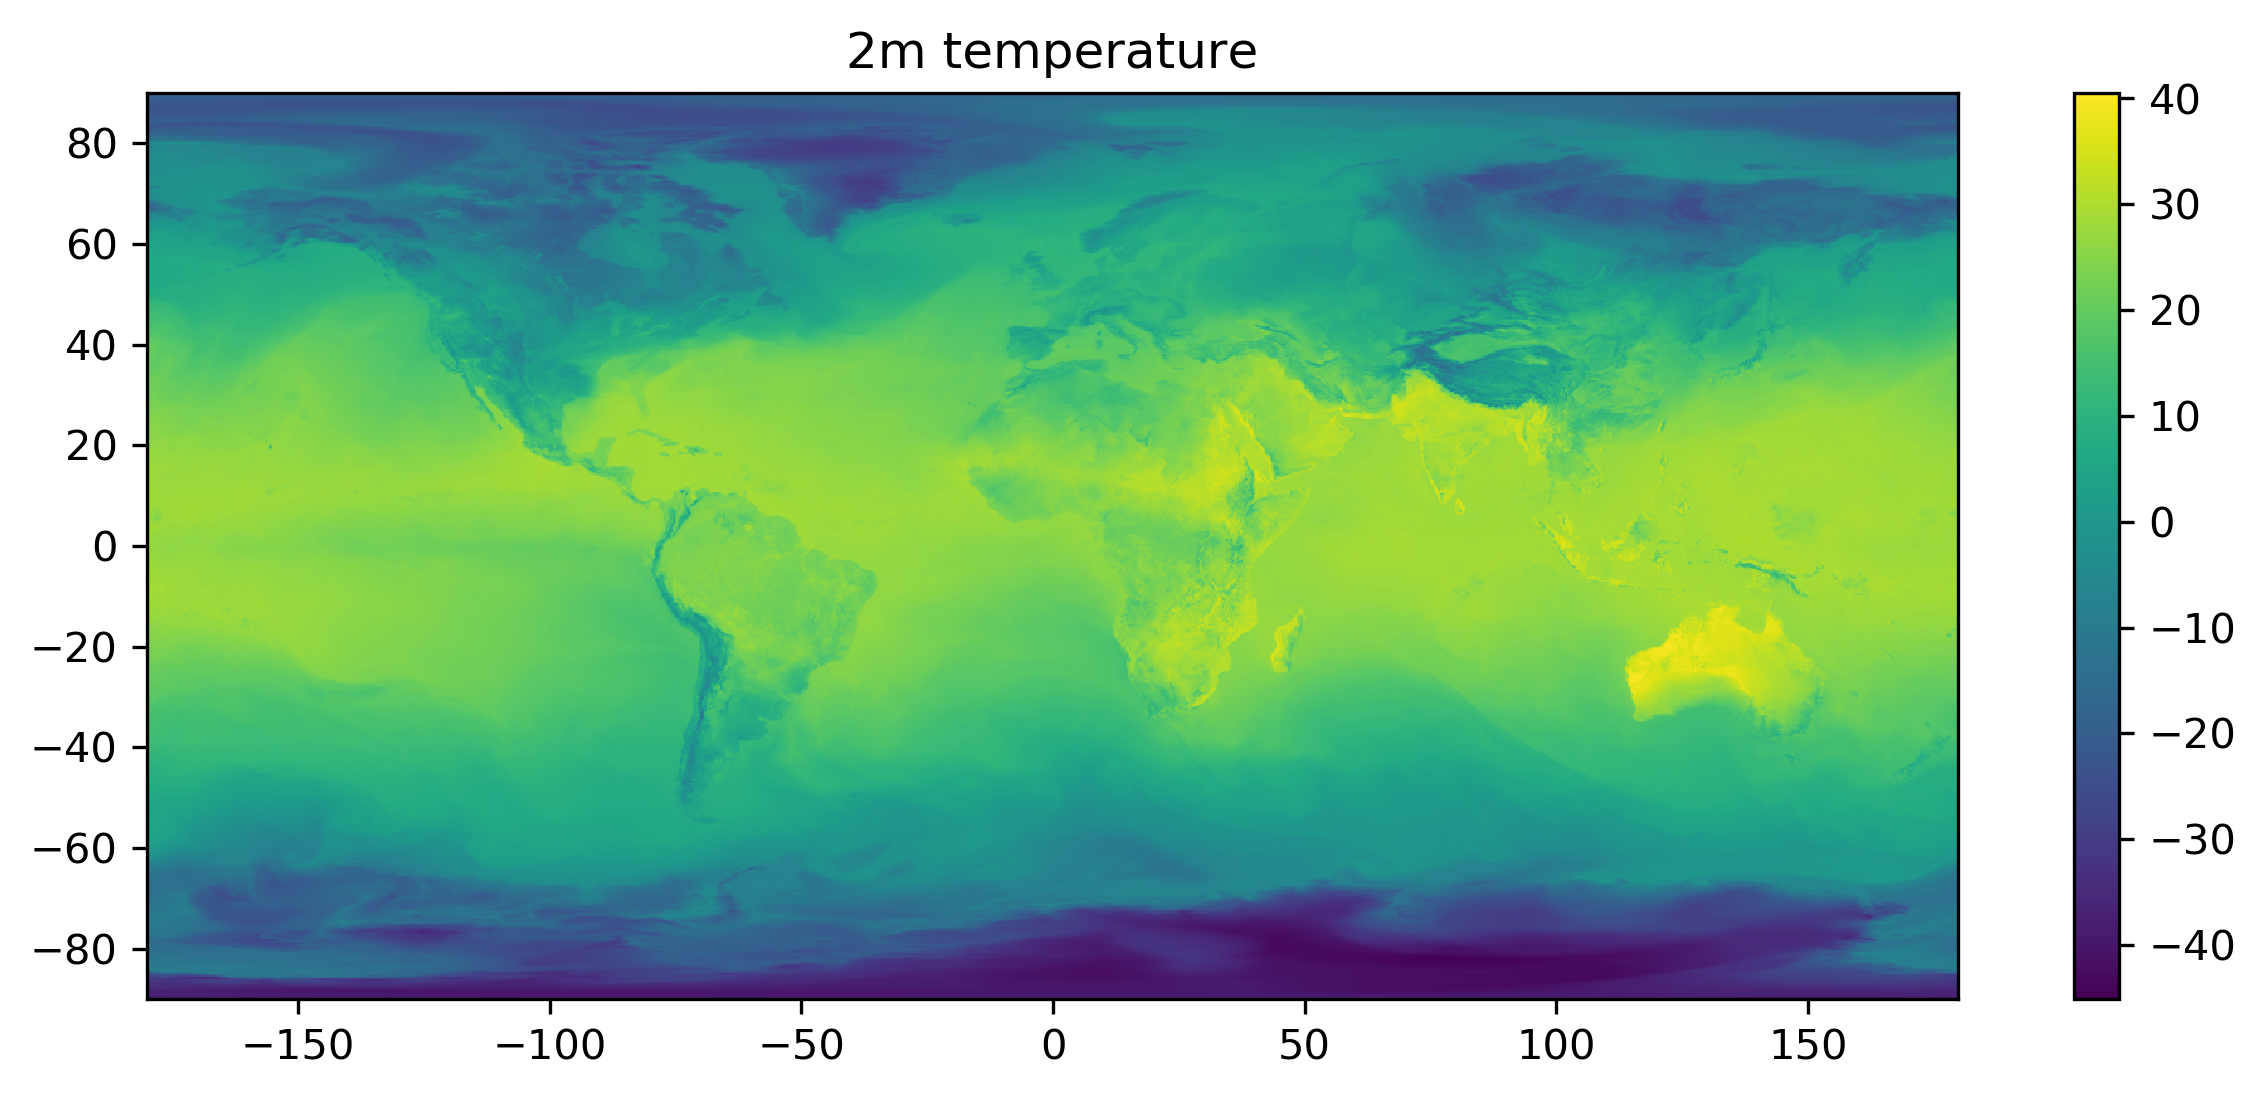

In [ ]:
# Example of use
gfs = GFS(path          = 'GFS', 
          bbox          = None, 
          bands_sf      = ['TMP'], 
          bands_pl      = None, 
          last_forecast = 'f001')
gfs.run(delete_old=True)

files = sorted(list(Path('GFS').iterdir()))
files = [f for f in files if f.suffix == '.nc']
ncData = Dataset(files[0])
t2m = ncData['2t'][:].data.squeeze() 
lon = ncData['lon'][:].data.squeeze()
lat = ncData['lat'][:].data.squeeze()
plt.figure(figsize=(10,4), dpi=300)
plt.pcolormesh(lon, lat, t2m-273.15)
plt.title('2m temperature')
plt.axis('image')
plt.colorbar();

In [ ]:
#hide
notebook2script()

Converted 00_external.ipynb.
Converted 01_download.ipynb.
Converted 02_cli.ipynb.
Converted 03_era5.ipynb.
Converted 04_geo.ipynb.
Converted 05_gfs.ipynb.
Converted index.ipynb.
